## Import Libraries

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import os
import json
import pandas as pd
from tqdm import tqdm
from scipy.stats import pearsonr, spearmanr
import numpy as np

## Functions

In [2]:
def parse_filename_safe(file_name):
    # Strip extension and normalize
    name = file_name.replace(".json", "")

    # Remove known prefix and normalize ain-7b
    name = name.replace("evaluation-", "")
    name = name.replace("ain-7b", "ain")

    # Split at most 2 times from the right
    parts = name.rsplit("-", maxsplit=2)

    if len(parts) == 3:
        dataset, ocr_model, llm_name = parts
    elif len(parts) == 2:
        dataset, ocr_model = parts
        llm_name = "ocr_only"
    else:
        raise ValueError(f"Unrecognized file name format: {file_name}")

    # Normalize llm_name
    llm_name = llm_name.lower().strip()

    # Remove trailing " (1)", " (2)", etc.
    llm_name = llm_name.split(" ")[0]  # if it's like "gpt (1)", becomes "gpt"

    # Final alias remapping (optional)
    if llm_name in ["gpt4o", "gpt-4o"]:
        llm_name = "gpt"
    elif llm_name in ["allam", "allam-7b"]:
        llm_name = "allam"

    return dataset.strip(), ocr_model.strip().lower(), llm_name



def load_evaluation_results(output_dir):
    avg_rows = []
    doc_rows = []

    for file_name in tqdm(os.listdir(output_dir)):
        if not file_name.startswith("evaluation-") or not file_name.endswith(".json"):
            continue

        dataset, ocr_model, llm_name = parse_filename_safe(file_name)
        full_path = os.path.join(output_dir, file_name)

        with open(full_path, "r", encoding="utf-8") as f:
            data = json.load(f)

        # Process average results
        avg_result = data.get("avg_results", {})
        avg_result.update({
            "dataset": dataset,
            "ocr_model": ocr_model,
            "llm_name": llm_name
        })
        avg_rows.append(avg_result)

        # Process per-document results
        for doc_id, doc_metrics in data.get("per_document_results", {}).items():
            doc_metrics.update({
                "doc_id": doc_id,
                "dataset": dataset,
                "ocr_model": ocr_model,
                "llm_name": llm_name
            })
            doc_rows.append(doc_metrics)

    df_avg = pd.DataFrame(avg_rows)
    df_doclevel = pd.DataFrame(doc_rows)
    return df_avg, df_doclevel


def format_doclevel_to_dict(df_doclevel):
    """
    Converts df_doclevel (from load_evaluation_results) to the nested dictionary format expected by visualize_all().
    Returns: dict[dataset|doc_id][model_key] = metrics_dict
    """
    doc_dict = {}
    for _, row in df_doclevel.iterrows():
        dataset = row["dataset"]
        doc_id = row["doc_id"]
        ocr_model = row["ocr_model"]
        llm_name = row["llm_name"]
        model_key = f"{llm_name}|{ocr_model}"
        doc_key = f"{dataset}|{doc_id}"

        if doc_key not in doc_dict:
            doc_dict[doc_key] = {}

        doc_dict[doc_key][model_key] = {
            "ocr_wer": row.get("ocr_wer"),
            "corrected_wer": row.get("corrected_wer"),
            # Add others here as needed
        }

    return doc_dict

## Visualization Functions

In [3]:
def compute_wer_deltas(doc_post_metric, llm_name):
    delta_wer_data = []

    for doc_key, results in doc_post_metric.items():
        for key, val in results.items():
            if key.startswith(llm_name) and "ocr_wer" in val and "corrected_wer" in val:
                ocr_wer = val["ocr_wer"]
                corrected_wer = val["corrected_wer"]
                delta = ocr_wer - corrected_wer
                delta_wer_data.append((ocr_wer, delta))

    if not delta_wer_data:
        return [], {}, (None, None)

    ocr_wers, delta_wers = zip(*delta_wer_data)
    pearson_corr, _ = pearsonr(ocr_wers, delta_wers)
    spearman_corr, _ = spearmanr(ocr_wers, delta_wers)

    bins = np.linspace(0, 1, 6)
    bin_indices = np.digitize(ocr_wers, bins)
    binned_avg_delta = {}
    for i in range(1, len(bins)):
        bin_vals = [delta_wers[j] for j in range(len(delta_wers)) if bin_indices[j] == i]
        if bin_vals:
            binned_avg_delta[f"{bins[i-1]:.1f}-{bins[i]:.1f}"] = np.mean(bin_vals)

    return list(zip(ocr_wers, delta_wers)), binned_avg_delta, (pearson_corr, spearman_corr)

def plot_scatter(delta_data, llm_name):
    df = pd.DataFrame(delta_data, columns=["OCR_WER", "Delta_WER"])
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df, x="OCR_WER", y="Delta_WER", alpha=0.6)
    plt.axhline(0, color="red", linestyle="--", label="No Improvement")
    plt.title(f"ΔWER vs OCR WER ({llm_name.upper()})")
    plt.xlabel("OCR WER")
    plt.ylabel("ΔWER (OCR - Corrected)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_binned_bar(binned_deltas, llm_name):
    df_bins = pd.DataFrame({
        "WER Range": list(binned_deltas.keys()),
        "Average ΔWER": list(binned_deltas.values())
    })
    plt.figure(figsize=(8, 5))
    sns.barplot(data=df_bins, x="WER Range", y="Average ΔWER", palette="Blues_d", edgecolor="black")
    plt.title(f"Average ΔWER by OCR WER Range ({llm_name.upper()})")
    plt.tight_layout()
    plt.show()

def plot_trend_with_band(delta_data, llm_name):
    df = pd.DataFrame(delta_data, columns=["OCR_WER", "Delta_WER"])
    df['bin'] = pd.cut(df['OCR_WER'], bins=np.linspace(0, 1, 11))
    grouped = df.groupby('bin', observed=True)['Delta_WER']
    means = grouped.mean()
    stds = grouped.std()

    valid = means.notna() & stds.notna()
    means = means[valid]
    stds = stds[valid]
    midpoints = [interval.mid for interval in means.index]
    plt.figure(figsize=(8, 6))
    plt.plot(midpoints, means, marker='o', label='Mean ΔWER')
    plt.fill_between(midpoints, means - stds, means + stds, alpha=0.3, label='±1 Std Dev')
    plt.axhline(0, color="red", linestyle="--")
    plt.title(f"ΔWER Trend by OCR WER ({llm_name.upper()})")
    plt.xlabel("OCR WER")
    plt.ylabel("Average ΔWER")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_decision_regions(delta_data, llm_name, threshold=0.01):
    df = pd.DataFrame(delta_data, columns=["OCR_WER", "Delta_WER"])
    df["Decision"] = df["Delta_WER"].apply(lambda x: "LLM Helpful" if x > threshold else "LLM Not Helpful")
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df, x="OCR_WER", y="Delta_WER", hue="Decision", style="Decision", palette="Set2")
    plt.axhline(threshold, color="black", linestyle="--", label="ΔWER Threshold")
    plt.title(f"Decision Regions for Post-Correction ({llm_name.upper()})")
    plt.xlabel("OCR WER")
    plt.ylabel("ΔWER")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_heatmap_density(delta_data, llm_name):
    df = pd.DataFrame(delta_data, columns=["OCR_WER", "Delta_WER"])
    df["OCR_bin"] = pd.cut(df["OCR_WER"], bins=np.linspace(0, 1, 10))
    df["Delta_bin"] = pd.cut(df["Delta_WER"], bins=np.linspace(-0.5, 0.5, 10))
    heatmap_data = df.groupby(["OCR_bin", "Delta_bin"]).size().unstack().fillna(0)
    plt.figure(figsize=(10, 6))
    sns.heatmap(heatmap_data, cmap="YlGnBu", annot=True, fmt=".0f")
    plt.title(f"Density of ΔWER vs OCR WER ({llm_name.upper()})")
    plt.xlabel("ΔWER")
    plt.ylabel("OCR WER")
    plt.tight_layout()
    plt.show()

def plot_boxplot_per_bin(delta_data, llm_name):
    df = pd.DataFrame(delta_data, columns=["OCR_WER", "Delta_WER"])
    df["WER Bin"] = pd.cut(df["OCR_WER"], bins=np.linspace(0, 1, 6))
    plt.figure(figsize=(9, 6))
    sns.boxplot(data=df, x="WER Bin", y="Delta_WER", palette="coolwarm")
    plt.title(f"Distribution of ΔWER by OCR WER Bin ({llm_name.upper()})")
    plt.ylabel("ΔWER")
    plt.xlabel("OCR WER Range")
    plt.tight_layout()
    plt.show()

def plot_improvement_rate(delta_data, llm_name):
    df = pd.DataFrame(delta_data, columns=["OCR_WER", "Delta_WER"])
    df["WER Bin"] = pd.cut(df["OCR_WER"], bins=np.linspace(0, 1, 6))
    df["Improved"] = df["Delta_WER"] > 0
    rate = df.groupby("WER Bin")["Improved"].mean().reset_index()
    plt.figure(figsize=(8, 5))
    sns.barplot(data=rate, x="WER Bin", y="Improved", palette="Greens_d")
    plt.title(f"% of Documents Improved by LLM per OCR WER Range ({llm_name.upper()})")
    plt.ylabel("% Improved")
    plt.xlabel("OCR WER Range")
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

def visualize_all(doc_post_metric, llm_name):
    print(f"computing wer_deltas for {llm_name}")
    delta_data, binned_deltas, (pearson, spearman) = compute_wer_deltas(doc_post_metric, llm_name)
    print(f"Done computing deltas for {llm_name}")
    print(f"Pearson Correlation: {pearson:.3f}" if pearson is not None else "Pearson Correlation: N/A")
    print(f"Spearman Correlation: {spearman:.3f}" if spearman is not None else "Spearman Correlation: N/A")

    print(f"Plotting for {llm_name}")
    plot_scatter(delta_data, llm_name)
    plot_binned_bar(binned_deltas, llm_name)
    plot_trend_with_band(delta_data, llm_name)
    plot_decision_regions(delta_data, llm_name)
    plot_heatmap_density(delta_data, llm_name)
    plot_boxplot_per_bin(delta_data, llm_name)
    plot_improvement_rate(delta_data, llm_name)


## Summary Table Function

In [4]:
def build_summary_from_df(df_avg, metrics=["wer", "cer"], save_path = None):
    # Map to your official display names
    pipeline_display_names = {
        ("tesseract", "ocr_only"): "Tesseract (OCR)",
        ("tesseract", "gpt"): "Tesseract + GPT-4o",
        ("tesseract", "allam"): "Tesseract + ALLam-7B",
        ("easyocr", "ocr_only"): "EasyOCR (OCR)",
        ("easyocr", "gpt"): "EasyOCR + GPT-4o",
        ("easyocr", "allam"): "EasyOCR + ALLam-7B",
        ("ain", "ocr_only"): "Ain-7B (OCR)",
        ("ain", "gpt"): "Ain-7B + GPT-4o",
        ("ain", "allam"): "Ain-7B + ALLam-7B",
        ("paddle", "ocr_only"): "PaddleOCR (OCR)",
        ("paddle", "gpt"): "PaddleOCR + GPT-4o",
        ("paddle", "allam"): "PaddleOCR + ALLam-7B"
    }

    data = {}
    seen_ocr = set()

    for _, row in df_avg.iterrows():
        dataset = row["dataset"]
        ocr_model = row["ocr_model"]
        llm_name = row["llm_name"]
        key = (ocr_model, llm_name)
        display = pipeline_display_names.get(key)
        ocr_display = pipeline_display_names.get((ocr_model, "ocr_only"))

        if dataset not in data:
            data[dataset] = {}

        for metric in metrics:
          ocr_metric_key = f"ocr_{metric}"
          corrected_metric_key = f"corrected_{metric}"

          # Extract from nested avg_results dictionary
          if isinstance(row["avg_results"], dict):
              ocr_value = row["avg_results"].get(ocr_metric_key)
              corrected_value = row["avg_results"].get(corrected_metric_key)
          else:
              continue  # skip if avg_results isn't available

          # Add OCR-only metric once
          if (dataset, ocr_model, metric) not in seen_ocr and ocr_value is not None and ocr_display:
              data[dataset][f"{ocr_display} ({metric})"] = ocr_value
              seen_ocr.add((dataset, ocr_model, metric))

          if corrected_value is not None and display:
              data[dataset][f"{display} ({metric})"] = corrected_value


    df_out = pd.DataFrame.from_dict(data, orient="index")
    df_total = pd.DataFrame(df_out.mean(numeric_only=True)).T
    df_total.index = ["Total"]
    summary_table = pd.concat([df_out, df_total])
    if save_path:
        summary_table.to_csv(save_path)
    return summary_table[sorted(summary_table.columns)]


def plot_improvement_rate_per_dataset(df_doclevel, llm_name):
    """
    Creates a bar plot showing the % of documents improved by the LLM for each dataset.
    Requires columns: 'dataset', 'ocr_wer', 'corrected_wer', 'llm_name'
    """
    df = df_doclevel[df_doclevel["llm_name"] == llm_name].copy()
    df["Improved"] = df["corrected_wer"] < df["ocr_wer"]

    # Group by dataset
    improvement_rate = df.groupby("dataset")["Improved"].mean().reset_index()

    # Sort by improvement %
    improvement_rate = improvement_rate.sort_values("Improved", ascending=False)

    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(data=improvement_rate, x="Improved", y="dataset", palette="Greens_d")
    plt.xlabel("% of Improved Documents")
    plt.ylabel("Dataset")
    plt.title(f"% of Documents Improved by LLM ({llm_name.upper()}) per Dataset")
    plt.xlim(0, 1)
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


def plot_bertscore_improvement_rate_per_dataset(df_doclevel, llm_name):
    """
    Bar plot: % of documents where BERTScore F1 improved after LLM correction, per dataset.
    Requires: 'dataset', 'ocr_bertscore_f1', 'corrected_bertscore_f1', 'llm_name'
    """
    df = df_doclevel[df_doclevel["llm_name"] == llm_name].copy()

    # Only keep rows with both values
    df = df[df["ocr_bertscore_f1"].notna() & df["corrected_bertscore_f1"].notna()]

    df["Improved"] = df["corrected_bertscore_f1"] > df["ocr_bertscore_f1"]

    # Group by dataset
    improvement_rate = df.groupby("dataset")["Improved"].mean().reset_index()
    improvement_rate = improvement_rate.sort_values("Improved", ascending=False)

    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(data=improvement_rate, x="Improved", y="dataset", palette="Blues_d")
    plt.xlabel("% of Improved Documents (BERTScore F1)")
    plt.ylabel("Dataset")
    plt.title(f"% of BERTScore F1 Improvements by LLM ({llm_name.upper()}) per Dataset")
    plt.xlim(0, 1)
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()




def plot_bertscore_comparison_per_dataset(df_avg, llm_name):
    df_llm = df_avg[df_avg["llm_name"] == llm_name].copy()
    df_ocr = df_avg[df_avg["llm_name"] == "ocr_only"][["dataset", "ocr_model", "ocr_bertscore_f1"]]
    df_ocr = df_ocr.rename(columns={"ocr_bertscore_f1": "BERTScore F1 (OCR-only)"})

    df_merge = df_ocr.merge(df_llm[["dataset", "ocr_model", "corrected_bertscore_f1"]], on=["dataset", "ocr_model"], how="left")

    llm_label = f"BERTScore F1 (LLM: {llm_name.upper()})"
    df_merge[llm_label] = df_merge["corrected_bertscore_f1"]

    df_melt = df_merge.melt(
        id_vars="dataset",
        value_vars=["BERTScore F1 (OCR-only)", llm_label],
        var_name="System",
        value_name="BERTScore F1"
    )
    df_melt = df_melt[df_melt["BERTScore F1"].notna()]

    dataset_order = df_merge.sort_values("BERTScore F1 (OCR-only)")["dataset"].tolist()

    plt.figure(figsize=(12, 6))
    sns.barplot(data=df_melt, x="dataset", y="BERTScore F1", hue="System", order=dataset_order)
    plt.title(f"BERTScore F1 Comparison per Dataset ({llm_name.upper()})")
    plt.xlabel("Dataset")
    plt.ylabel("BERTScore F1")
    plt.xticks(rotation=45, ha="right")
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.legend(title="System")
    plt.show()




In [5]:
def plot_wer_comparison_per_dataset(df_avg, llm_name, ocr_model):
    df_avg = df_avg.copy()

    # Normalize all
    df_avg["dataset"] = df_avg["dataset"].str.lower().str.strip()
    df_avg["ocr_model"] = df_avg["ocr_model"].str.lower().str.strip()
    df_avg["llm_name"] = df_avg["llm_name"].str.lower().str.strip()
    llm_name = llm_name.strip().lower()
    ocr_model = ocr_model.strip().lower()

    # Filter to only the OCR model of interest
    df_model = df_avg[df_avg["ocr_model"] == ocr_model]

    # Split OCR and LLM
    df_ocr = df_model[df_model["llm_name"] == "ocr_only"][["dataset", "ocr_wer"]]
    df_llm = df_model[df_model["llm_name"] == llm_name][["dataset", "corrected_wer"]]

    if df_ocr.empty:
        print(f"No OCR-only entries for '{ocr_model}'")
        return
    if df_llm.empty:
        print(f"No LLM entries for '{ocr_model} + {llm_name}'")
        return

    # Merge on dataset
    df_merge = pd.merge(df_ocr, df_llm, on="dataset", how="left")

    df_merge = df_merge.rename(columns={
        "ocr_wer": "WER (OCR-only)",
        "corrected_wer": f"WER (LLM: {llm_name.upper()})"
    })

    df_melt = df_merge.melt(
        id_vars="dataset",
        value_vars=["WER (OCR-only)", f"WER (LLM: {llm_name.upper()})"],
        var_name="System",
        value_name="WER"
    )

    if df_melt.empty:
        print("Melted DataFrame is empty")
        return

    dataset_order = df_merge.sort_values("WER (OCR-only)")["dataset"].tolist()

    plt.figure(figsize=(12, 6))
    sns.barplot(data=df_melt, x="dataset", y="WER", hue="System", order=dataset_order)
    plt.title(f"WER Comparison — OCR: {ocr_model.upper()} | LLM: {llm_name.upper()}")
    plt.xlabel("Dataset")
    plt.ylabel("Word Error Rate (WER)")
    plt.xticks(rotation=45, ha="right")
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.legend(title="System")
    plt.tight_layout()
    plt.show()


## Environment Setup

In [7]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [8]:
output_dir = '/content/drive/MyDrive/Righting-Writing-eval-results'
while not os.path.exists(output_dir):
    output_dir = input("Enter the evaluation results dir (e.g., /content/drive/MyDrive/righting-writing_results): ")
    if not os.path.exists(output_dir):
        tqdm.write(f"Path '{output_dir}' does not exist. Please try again.")

## Loading Data

In [9]:
df_avg, df_doclevel = load_evaluation_results(output_dir)

100%|██████████| 96/96 [00:52<00:00,  1.84it/s]


In [10]:
df_avg.head()

,ocr_cer,ocr_wer,ocr_edit_distance,ocr_bertscore_f1,ocr_wer_edit_distance,corrected_cer,corrected_wer,corrected_edit_distance,corrected_bertscore_f1,corrected_wer_edit_distance,dataset,ocr_model,llm_name
0,0.813096,1.011628,33.550607,0.607942,33.516194,0.770683,1.003589,31.799595,0.683771,31.787449,synthesizear,paddle,gpt
1,0.782464,1.005481,64.080483,0.608289,63.329980,0.744677,0.973989,61.046278,0.687021,60.476861,patsocr,paddle,gpt
2,0.790948,1.002707,39.088235,0.643401,39.088235,0.787931,1.008706,38.582353,0.662242,38.582353,historyar,paddle,gpt
3,0.725152,0.998571,272.300000,0.600649,268.700000,0.739954,0.998276,277.600000,0.610947,274.300000,historicalbooks,paddle,gpt
4,0.862147,1.233586,8.250000,0.722558,8.015152,0.899571,1.260101,8.462121,0.724147,8.189394,adab,paddle,gpt


In [11]:
df_doclevel.head()

,ocr_cer,ocr_wer,ocr_edit_distance,ocr_bertscore_f1,ocr_wer_edit_distance,corrected_cer,corrected_wer,corrected_edit_distance,corrected_bertscore_f1,corrected_wer_edit_distance,doc_id,dataset,ocr_model,llm_name
0,0.810811,1.0,30,0.594462,30,0.756757,1.000,28,0.657750,28,doc_0,synthesizear,paddle,gpt
1,0.893617,1.0,42,0.581244,42,0.893617,1.125,42,0.666432,42,doc_1,synthesizear,paddle,gpt
2,0.829268,1.0,34,0.591317,34,0.902439,1.000,37,0.657254,37,doc_2,synthesizear,paddle,gpt
3,0.792453,1.0,42,0.570234,42,0.754717,1.000,40,0.674635,40,doc_3,synthesizear,paddle,gpt
4,0.833333,1.0,35,0.665228,35,0.809524,1.000,34,0.668008,34,doc_4,synthesizear,paddle,gpt


In [12]:
df_avg["ocr_model"].unique()

array(['paddle', 'tesseract', 'easyocr', 'ain'], dtype=object)

In [13]:
doc_post_metric = format_doclevel_to_dict(df_doclevel)

## Visualization

computing wer_deltas for allam
Done computing deltas for allam
Pearson Correlation: 0.189
Spearman Correlation: 0.350
Plotting for allam


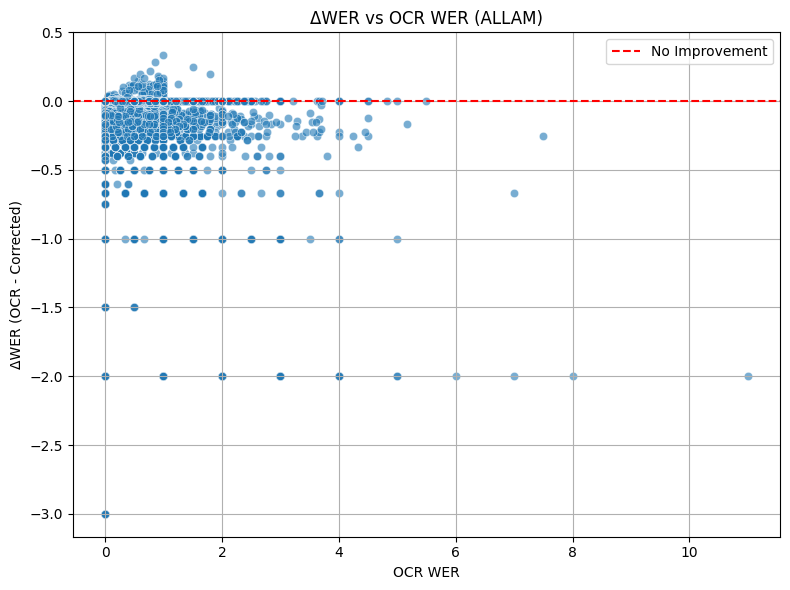

<ipython-input-3-92d7ebd6eef9>:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_bins, x="WER Range", y="Average ΔWER", palette="Blues_d", edgecolor="black")


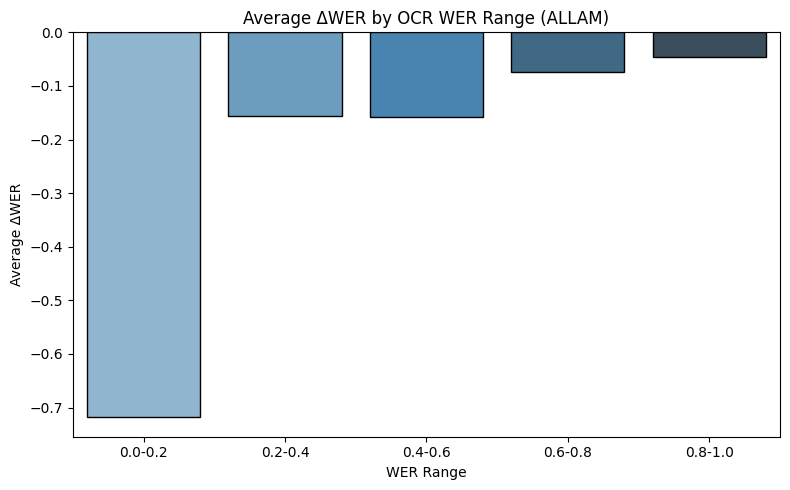

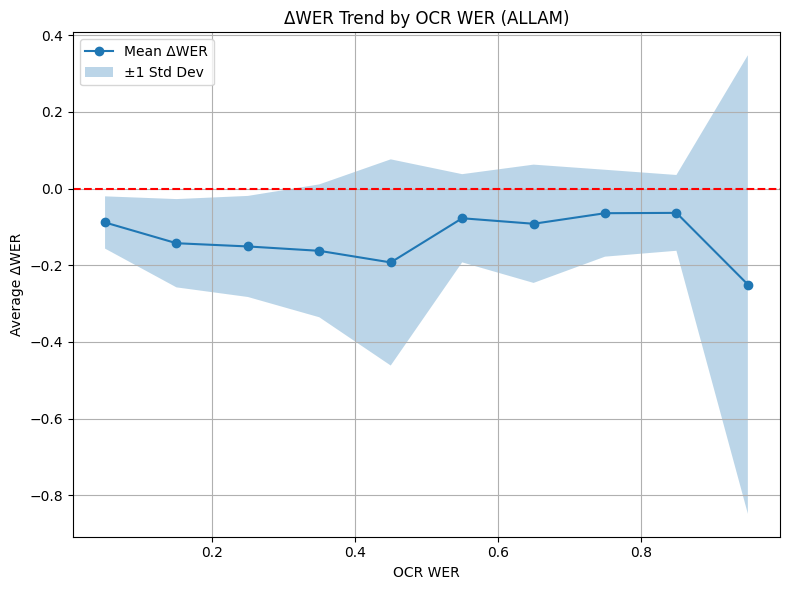

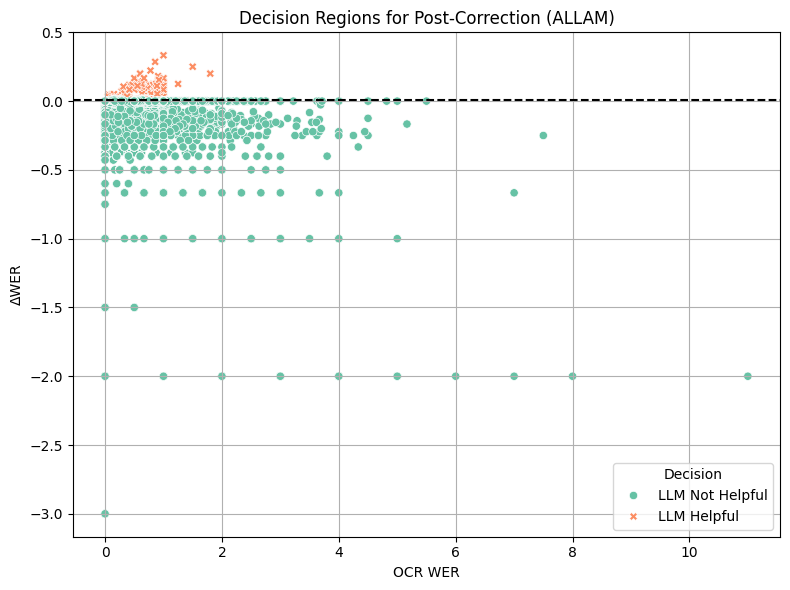

<ipython-input-3-92d7ebd6eef9>:93: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heatmap_data = df.groupby(["OCR_bin", "Delta_bin"]).size().unstack().fillna(0)


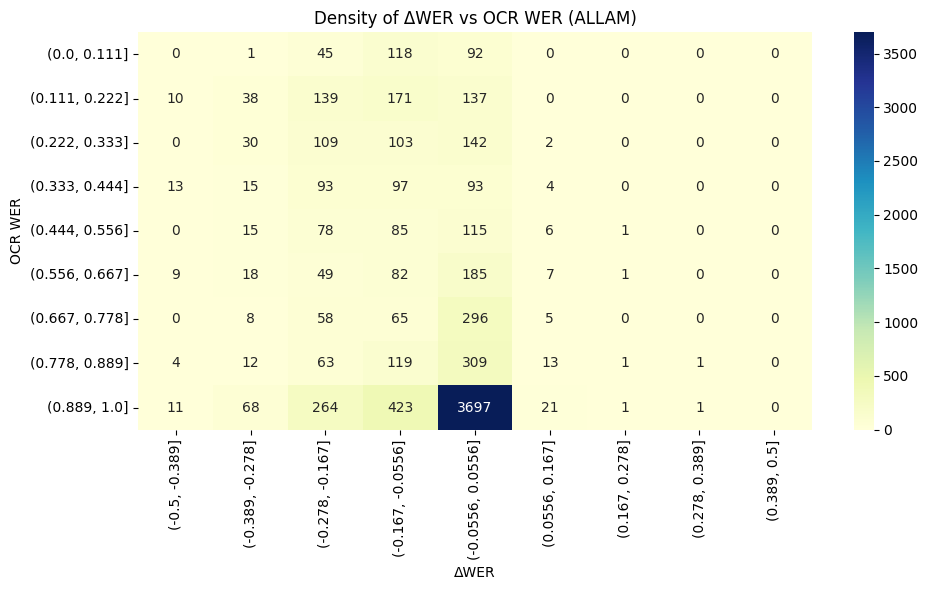

<ipython-input-3-92d7ebd6eef9>:106: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="WER Bin", y="Delta_WER", palette="coolwarm")


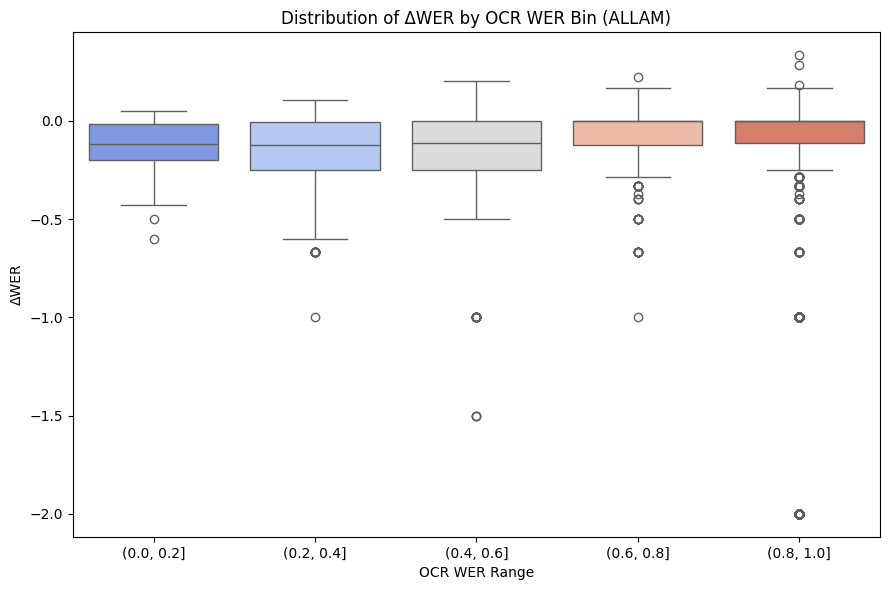

<ipython-input-3-92d7ebd6eef9>:117: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate = df.groupby("WER Bin")["Improved"].mean().reset_index()
<ipython-input-3-92d7ebd6eef9>:119: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=rate, x="WER Bin", y="Improved", palette="Greens_d")


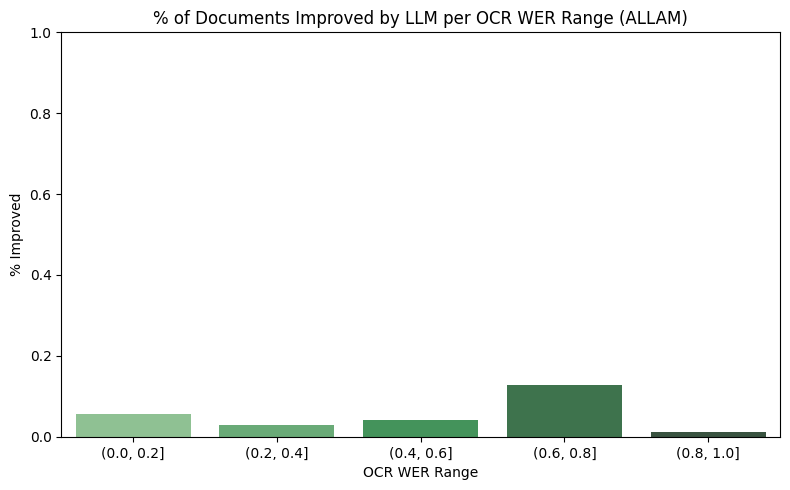

In [14]:
visualize_all(doc_post_metric, "allam")

computing wer_deltas for gpt
Done computing deltas for gpt
Pearson Correlation: 0.411
Spearman Correlation: 0.428
Plotting for gpt


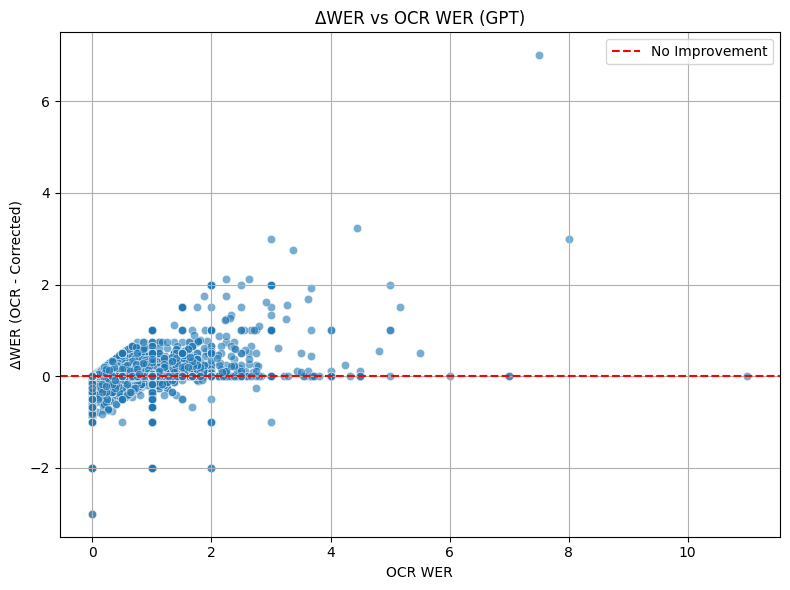

<ipython-input-3-92d7ebd6eef9>:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_bins, x="WER Range", y="Average ΔWER", palette="Blues_d", edgecolor="black")


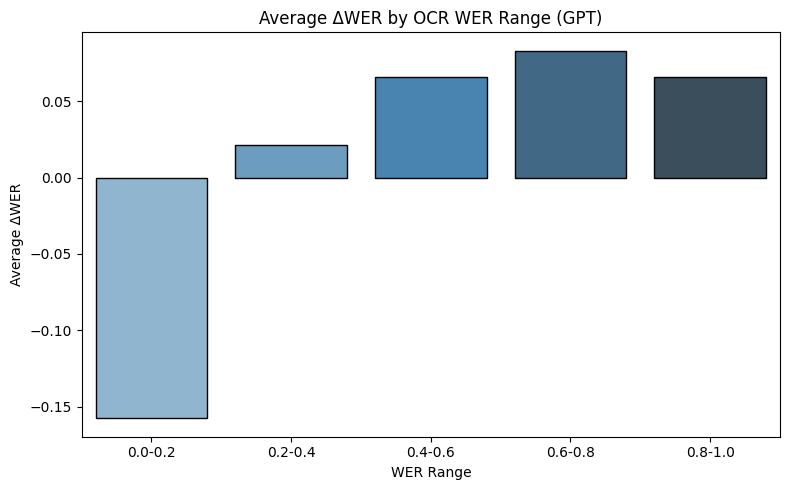

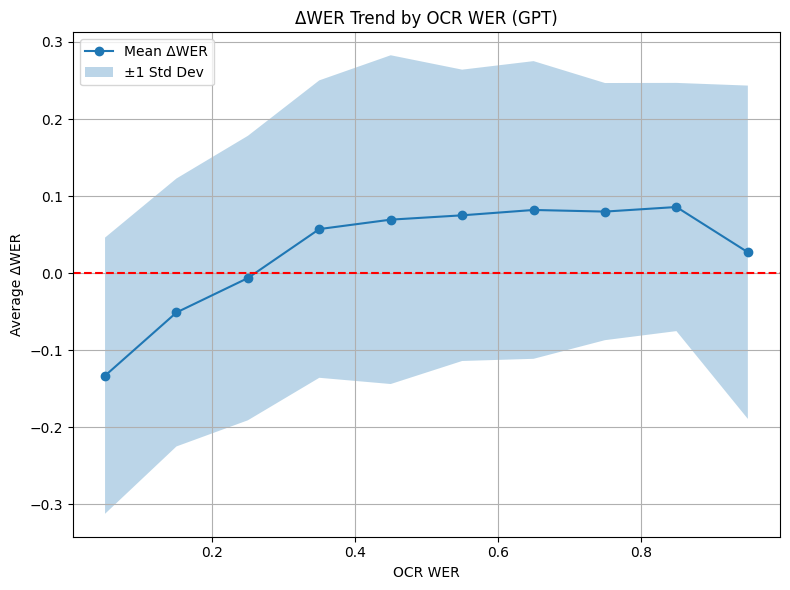

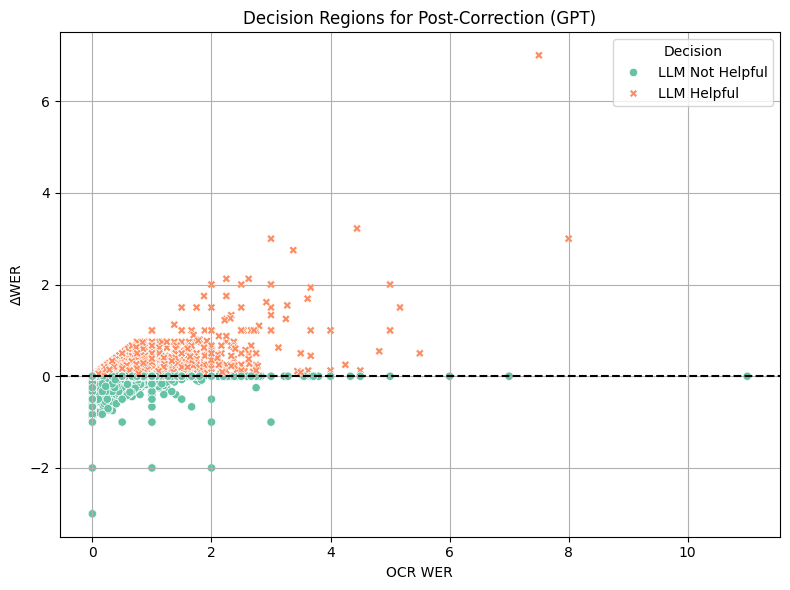

<ipython-input-3-92d7ebd6eef9>:93: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heatmap_data = df.groupby(["OCR_bin", "Delta_bin"]).size().unstack().fillna(0)


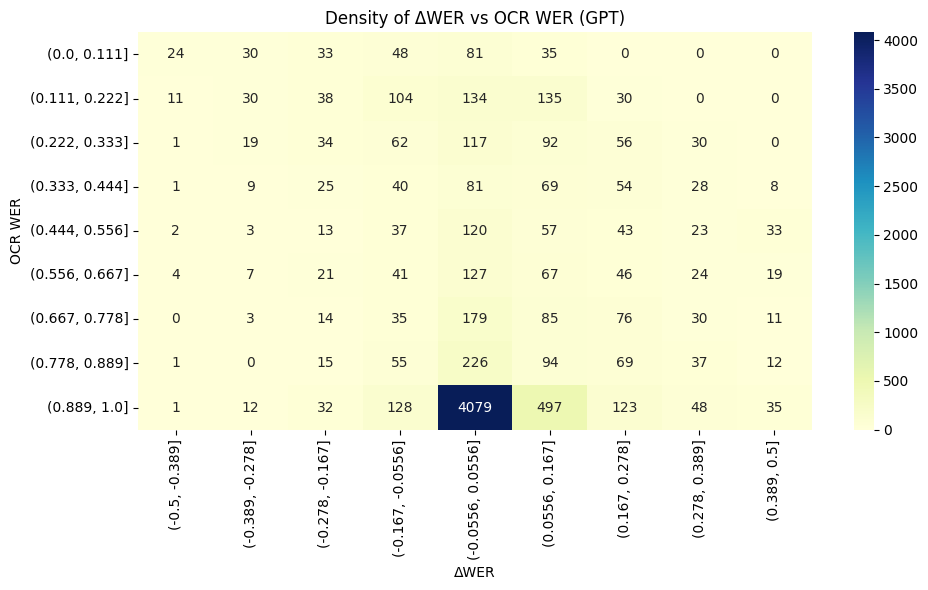

<ipython-input-3-92d7ebd6eef9>:106: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="WER Bin", y="Delta_WER", palette="coolwarm")


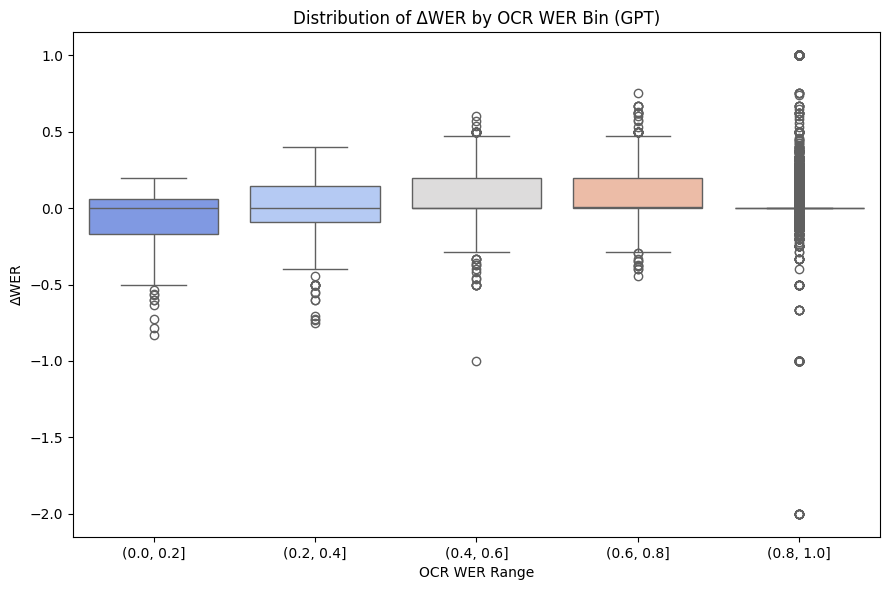

<ipython-input-3-92d7ebd6eef9>:117: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate = df.groupby("WER Bin")["Improved"].mean().reset_index()
<ipython-input-3-92d7ebd6eef9>:119: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=rate, x="WER Bin", y="Improved", palette="Greens_d")


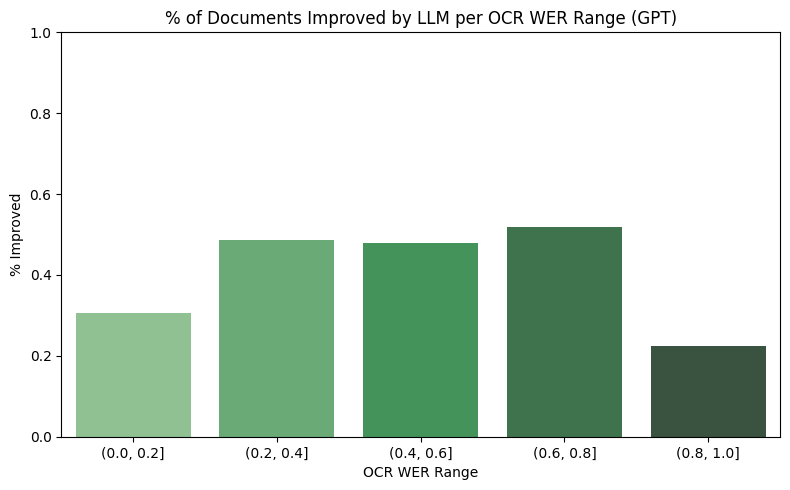

In [15]:
visualize_all(doc_post_metric, "gpt")

<ipython-input-4-5c3171fba4a0>:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=improvement_rate, x="Improved", y="dataset", palette="Greens_d")


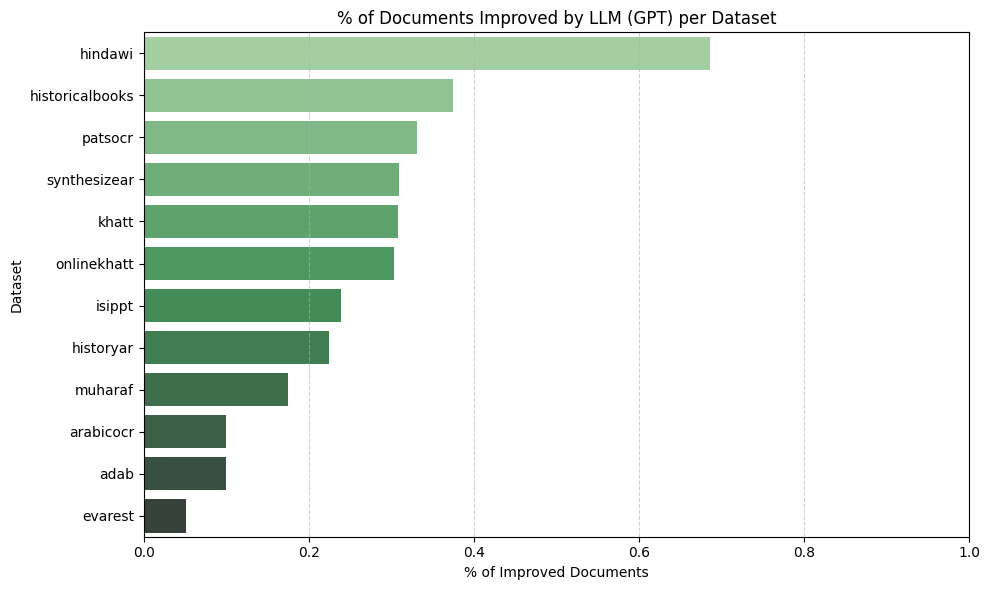

In [16]:
plot_improvement_rate_per_dataset(df_doclevel, "gpt")

<ipython-input-4-5c3171fba4a0>:105: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=improvement_rate, x="Improved", y="dataset", palette="Blues_d")


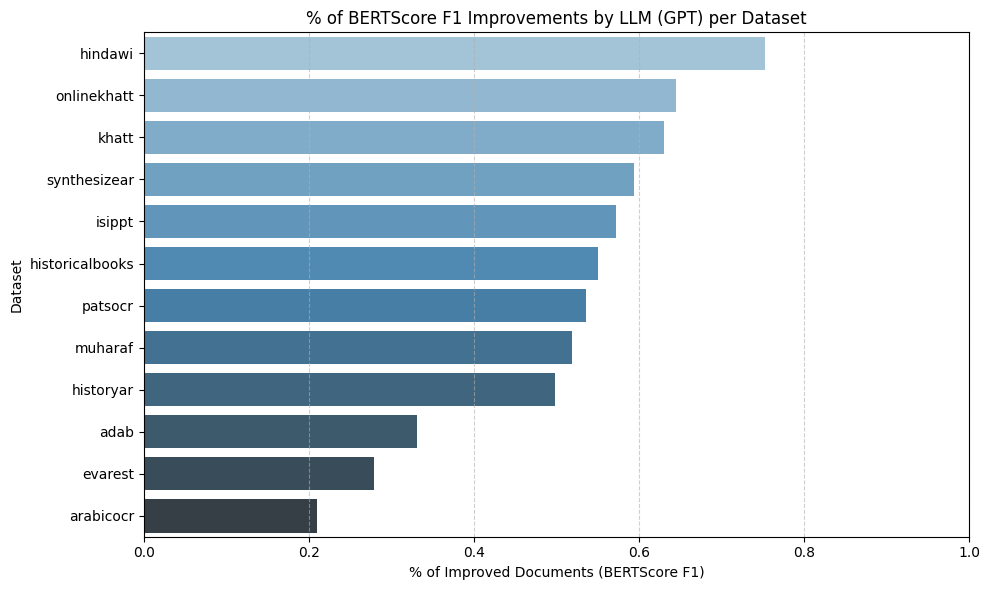

In [17]:
plot_bertscore_improvement_rate_per_dataset(df_doclevel, "gpt")

In [18]:
plot_wer_comparison_per_dataset(df_avg, "gpt", "tesseract")

No OCR-only entries for 'tesseract'


## Results Summary